## 0. Info & Summary
작성일 : 211111 / 작성자 : 김선진

## 1. 아이템 정의
DSP300 기준 상승구간의 X 변동성을 Randomforest와 PCA를 통해 확인

## 2. 목적
DSP300의 상승구간의 정보량을 확인하고, Randomforest 와 PCA를 바탕으로 검토


----------------------------------
## 3. 방법 및 코드

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os, warnings, shutil
import warnings, random, openpyxl
warnings.filterwarnings(action='ignore')  

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)
pd.set_option('max_columns', 130, 'max_rows', 250)



In [ ]:
import plotly.graph_objects as go

In [ ]:
def search_dsp_idx(dsp_array):
    std_list = []
    for i in range(len(dsp_array)):
        chunck = 5
        if i+chunck > len(dsp_array): break
        dsp_temp = dsp_array[i:i+chunck]
        std_list.append(np.diff(dsp_temp))
    ascent_idx_list = np.where(np.array(std_list)>100)[0]
    descent_idx_list = np.where(np.array(std_list)<-100)[0]

    # 상승/하강구간의 최초 지점을 찾아줌
    past_ascent_idx = 0
    new_ascent_idx_list = []
    for ascent_idx in ascent_idx_list:
        if past_ascent_idx + 30 < ascent_idx: 
            new_ascent_idx_list.append(ascent_idx)
        past_ascent_idx = ascent_idx

    past_descent_idx = 0
    new_descent_idx_list = []
    for descent_idx in descent_idx_list:
        if past_descent_idx + 30 < descent_idx: 
            new_descent_idx_list.append(descent_idx)
        past_descent_idx = descent_idx
    return new_descent_idx_list, new_ascent_idx_list

In [ ]:
raw_train_df = pd.read_pickle("C:\\Users\\OnePredict\\Desktop\\lotus_211111_ascent-train-test-dataset[565]\\lotus_train_df.pkl")
raw_test_df = pd.read_pickle("C:\\Users\\OnePredict\\Desktop\\lotus_211111_ascent-train-test-dataset[565]\\lotus_test_df.pkl")
print(raw_train_df.shape, raw_test_df.shape)
display(raw_train_df.head(), raw_test_df.head())

(5265, 940) (405, 940)


,log_number,state,Date,esu_PROC_RCP_STEP,esu_RPM,esu_Bowl_Exh_R,esu_Double_Feature_SCANCOUNT,esu_IPA_SCANCOUNT,esu_MRNozzle_SCANCOUNT,esu_Chuck_Bowl_Sh1_FLOW,esu_BACK_DI_FLOW,esu_BACK_N2_FLOW,esu_BACK_HOTDI_FLOW,esu_AIR_SUCTION_FLOW,esu_CHM_EXHAUST_FLOW,esu_BACKSIDE_CAP_N2_FLOW,esu_FINAL_DIW_FLOW,esu_CHM_DHF_FLOW,esu_CHM_DSP300_FLOW,esu_BACK_SC1_FLOW,esu_BACK_DHF_FLOW,esu_BACK_DSP300_FLOW,esu_AEROSOL_N2_FLOW,esu_AEROSOL_DI_FLOW,esu_CHM_SC1_DF_FLOW,esu_IPA_N2_FLOW,esu_HOT_IPA_FLOW,esu_HIPA HICV IN,esu_HIPA HICV OUT,esu_DIW1_FLOW,esu_DIW2_FLOW,esu_SSONICSWERVE,esu_WAFERSAFETY,esu_Environ_Exh,esu_SEL_THETA_POS1,esu_SEL_THETA_POS2,esu_SEL_THETA_POS3,esu_SEL_THETA_VEL1,esu_SEL_THETA_VEL2,esu_SEL_THETA_VEL3,esu_Double_Feature_THETA_POS,esu_Double_Feature_THETA_VEL,esu_Double_Feature_Z_POS,esu_IPA_THETA_POS,esu_IPA_THETA_VEL,esu_IPA_Z_POS,esu_MRNozzle_THETA_POS,esu_MRNozzle_THETA_VEL,esu_MRNozzle_Z_POS,esu_Hepa,esu_FLOW_SWITCH1,esu_FLOW_SWITCH2,esu_FLOW_SWITCH3,esu_CHAMBER_DOOR_STATUS,esu_SOUND_WAVE,esu_WAFER_TEMP,esu_HEPA_OUTPUT,esu_CDA_HEIGHT,esu_CDA_PRESS,esu_PIEZO_DRIVER_SETMODE,esu_HPU_PRESSURE,esu_REAL_BOWL_POS_STATUS,esu_AUTO_DAMPER_DEGREE_INFO1,esu_AUTO_DAMPER_DEGREE_INFO2,esu_CHAMBER_TEMPERTURE,...,tank10_Sub2_Density_Check,tank10_Main_Density_Check,tank10_Dnst1OfH2O2_Tank,tank10_Dnst1OfOther_Tank,tank10_Dnst2OfH2O2_Tank,tank10_Dnst2OfOther_Tank,tank10_DnstOfH2O2_Supply,tank10_DnstOfOther_Supply,tank10_RateOfACT,tank10_RateOfH2O2,tank10_RateOfDIW,tank10_TempOfMixHeater1Set,tank10_TempOfMixHeater1Act,tank10_TempOfMixHeater2Set,tank10_TempOfMixHeater2Act,tank10_TempOfSupplyHeaterSet,tank10_TempOfSupplyHeaterAct,tank10_TempOfMixtank1,tank10_TempOfMixtank2,tank10_TempOfMixtank3,tank10_TempOfReturnAct,tank10_LifeTimeSet,tank10_LifeTime,tank10_LifeCount,tank10_MainphMeter,tank10_FlowOfSub1ConPCW,tank10_FlowOfSub2ConPCW,tank10_FlowOfMainConPCW,tank10_PressOfPump,tank10_PressOfSupply,tank10_FlowOfSupply,tank10_FlowOfPCW,tank10_Exhaust,tank10_SetFlowOfACT,tank10_SetFlowOfH2O2,tank10_SetFlowOfCDIW,tank10_SetFlowOfHDIW,tank10_CurFlowOfACT,tank10_CurFlowOfH2O2,tank10_CurFlowOfCDIW,tank10_CurFlowOfHDIW,tank10_FlowOfACT,tank10_FlowOfH2O2,tank10_FlowOfCDIW,tank10_FlowOfHDIW,tank10_ACT_IN_PRESS,tank10_H2O2_IN_PRESS,tank10_Sub1phMeter,tank10_Sub2phMeter,tank10_PressOfRecycle_Filter_In,tank10_PressOfRecycle_Filter_Out,tank10_PressOfFilter_Out,tank10_CurrentOutputOfMixHeater,tank10_StateOfMixHeaterFullPower,tank10_StateOfSubCirPump,tank10_PressOfSubCirPumpInAir,tank10_StateOfMainCirPump,tank10_PressOfMainCirPumpInAir,tank10_StateOfMainSubPumpExch,tank10_TempOfDnstChemSampling,tank10_StateOfDnstMeasuring,tank10_HalogenOfUV_DS,tank10_HalogenOfUV_DR,tank10_HalogenOfNIR_DS,tank10_HalogenOfNIR_DR
0,1261,normal,2021-08-10 11:33:46.200,0.0,500.0,178.0,0.0,0.0,1.0,0.0,0.0,39.0,500.0,0.0,0.0,145.0,0.0,500.0,501.0,500.0,502.0,806.0,0.0,0.0,500.0,0.0,243.0,128.0,88.0,1212.0,1009.0,0.0,0.0,69.0,14998.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,491.0,700.0,459.0,700.0,700.0,699.0,497.0,462.0,727.0,1440.0,0.0,0.0,0.0,0.0,295.8,288.8,752.8,285.6,119.8,0.0,19.6,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,110.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1261,normal,2021-08-10 11:33:46.300,0.0,500.0,175.0,0.0,0.0,1.0,0.0,0.0,39.0,500.0,0.0,0.0,145.0,0.0,500.0,501.0,500.0,502.0,806.0,0.0,0.0,500.0,0.0,241.0,128.0,88.0,1208.0,1008.0,0.0,0.0,69.0,14998.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,491.0,700.0,459.0,700.0,700.0,699.0,497.0,462.0,727.0,1440.0,0.0,0.0,0.0,0.0,295.7,288.7,753.2,286.9,120.2,0.0,19.4,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,110.8,0.0,0.0,0.0,0.0,0.

,log_number,state,Date,esu_PROC_RCP_STEP,esu_RPM,esu_Bowl_Exh_R,esu_Double_Feature_SCANCOUNT,esu_IPA_SCANCOUNT,esu_MRNozzle_SCANCOUNT,esu_Chuck_Bowl_Sh1_FLOW,esu_BACK_DI_FLOW,esu_BACK_N2_FLOW,esu_BACK_HOTDI_FLOW,esu_AIR_SUCTION_FLOW,esu_CHM_EXHAUST_FLOW,esu_BACKSIDE_CAP_N2_FLOW,esu_FINAL_DIW_FLOW,esu_CHM_DHF_FLOW,esu_CHM_DSP300_FLOW,esu_BACK_SC1_FLOW,esu_BACK_DHF_FLOW,esu_BACK_DSP300_FLOW,esu_AEROSOL_N2_FLOW,esu_AEROSOL_DI_FLOW,esu_CHM_SC1_DF_FLOW,esu_IPA_N2_FLOW,esu_HOT_IPA_FLOW,esu_HIPA HICV IN,esu_HIPA HICV OUT,esu_DIW1_FLOW,esu_DIW2_FLOW,esu_SSONICSWERVE,esu_WAFERSAFETY,esu_Environ_Exh,esu_SEL_THETA_POS1,esu_SEL_THETA_POS2,esu_SEL_THETA_POS3,esu_SEL_THETA_VEL1,esu_SEL_THETA_VEL2,esu_SEL_THETA_VEL3,esu_Double_Feature_THETA_POS,esu_Double_Feature_THETA_VEL,esu_Double_Feature_Z_POS,esu_IPA_THETA_POS,esu_IPA_THETA_VEL,esu_IPA_Z_POS,esu_MRNozzle_THETA_POS,esu_MRNozzle_THETA_VEL,esu_MRNozzle_Z_POS,esu_Hepa,esu_FLOW_SWITCH1,esu_FLOW_SWITCH2,esu_FLOW_SWITCH3,esu_CHAMBER_DOOR_STATUS,esu_SOUND_WAVE,esu_WAFER_TEMP,esu_HEPA_OUTPUT,esu_CDA_HEIGHT,esu_CDA_PRESS,esu_PIEZO_DRIVER_SETMODE,esu_HPU_PRESSURE,esu_REAL_BOWL_POS_STATUS,esu_AUTO_DAMPER_DEGREE_INFO1,esu_AUTO_DAMPER_DEGREE_INFO2,esu_CHAMBER_TEMPERTURE,...,tank10_Sub2_Density_Check,tank10_Main_Density_Check,tank10_Dnst1OfH2O2_Tank,tank10_Dnst1OfOther_Tank,tank10_Dnst2OfH2O2_Tank,tank10_Dnst2OfOther_Tank,tank10_DnstOfH2O2_Supply,tank10_DnstOfOther_Supply,tank10_RateOfACT,tank10_RateOfH2O2,tank10_RateOfDIW,tank10_TempOfMixHeater1Set,tank10_TempOfMixHeater1Act,tank10_TempOfMixHeater2Set,tank10_TempOfMixHeater2Act,tank10_TempOfSupplyHeaterSet,tank10_TempOfSupplyHeaterAct,tank10_TempOfMixtank1,tank10_TempOfMixtank2,tank10_TempOfMixtank3,tank10_TempOfReturnAct,tank10_LifeTimeSet,tank10_LifeTime,tank10_LifeCount,tank10_MainphMeter,tank10_FlowOfSub1ConPCW,tank10_FlowOfSub2ConPCW,tank10_FlowOfMainConPCW,tank10_PressOfPump,tank10_PressOfSupply,tank10_FlowOfSupply,tank10_FlowOfPCW,tank10_Exhaust,tank10_SetFlowOfACT,tank10_SetFlowOfH2O2,tank10_SetFlowOfCDIW,tank10_SetFlowOfHDIW,tank10_CurFlowOfACT,tank10_CurFlowOfH2O2,tank10_CurFlowOfCDIW,tank10_CurFlowOfHDIW,tank10_FlowOfACT,tank10_FlowOfH2O2,tank10_FlowOfCDIW,tank10_FlowOfHDIW,tank10_ACT_IN_PRESS,tank10_H2O2_IN_PRESS,tank10_Sub1phMeter,tank10_Sub2phMeter,tank10_PressOfRecycle_Filter_In,tank10_PressOfRecycle_Filter_Out,tank10_PressOfFilter_Out,tank10_CurrentOutputOfMixHeater,tank10_StateOfMixHeaterFullPower,tank10_StateOfSubCirPump,tank10_PressOfSubCirPumpInAir,tank10_StateOfMainCirPump,tank10_PressOfMainCirPumpInAir,tank10_StateOfMainSubPumpExch,tank10_TempOfDnstChemSampling,tank10_StateOfDnstMeasuring,tank10_HalogenOfUV_DS,tank10_HalogenOfUV_DR,tank10_HalogenOfNIR_DS,tank10_HalogenOfNIR_DR
0,1275,diff_normal,2021-08-10 11:57:20.700,0.0,500.0,177.0,0.0,0.0,1.0,0.0,0.0,41.0,500.0,0.0,0.0,145.0,0.0,500.0,503.0,498.0,499.0,806.0,0.0,0.0,499.0,0.0,239.0,128.0,88.0,1217.0,1001.0,0.0,0.0,70.0,14998.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,492.0,700.0,459.0,700.0,698.0,699.0,497.0,462.0,724.0,1440.0,0.0,0.0,0.0,0.0,285.0,288.0,724.0,307.0,122.0,0.0,17.0,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1275,diff_normal,2021-08-10 11:57:20.800,0.0,500.0,177.0,0.0,0.0,1.0,0.0,0.0,41.0,500.0,0.0,0.0,145.0,0.0,502.0,498.0,498.0,502.0,806.0,0.0,0.0,499.0,0.0,239.0,128.0,88.0,1217.0,1001.0,0.0,0.0,70.0,14998.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,492.0,700.0,459.0,700.0,698.0,699.0,497.0,462.0,724.0,1440.0,0.0,0.0,0.0,0.0,285.0,288.0,724.0,307.0,122.0,0.0,17.0,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,141.0,0.0,0.0,

In [ ]:
raw_ttl_df = pd.concat([raw_train_df, raw_test_df],0).sort_values(['Date'],ascending=True).reset_index(drop=True)
raw_ttl_df.shape

(5670, 940)

----------------------------------
## 4. Train test 분류 

In [ ]:

Y_trian = raw_train_df['esu_CHM_DSP300_FLOW']
# 절대 쓰면 안되는 column 모음 
never_use_column = [
    'Date',
    'esu_CHM_DSP300_FLOW',
    'esu_CHM_DSP300_APAC_Sensor_Data',
    'esu_BACK_DSP300_FLOW',
    'esu_BACK_DSP300_APAC_Sensor_Data',
    'state',
    'log_number',
    'esu_CHM_DSP300_APAC_Current',
    'esu_BACK_DSP300_APAC_Current',
]
after_check = [ 
    # "esu_DIW2_APAC_Sensor_Data",
    # "esu_DIW2_FLOW",
    # "esu_DIW1_APAC_Sensor_Data",
    # "esu_DIW1_FLOW",
    # "esu_1Axis_CommandPulse",
    # "esu_1Axis_ActualPulse",
    # "esu_DIW2_APAC_Current",
    # "esu_DIW1_APAC_Current",
    # "esu_MRNozzle_THETA_POS",
    #### 여기까지 DIW 관련 ####
    # "esu_Bowl_Exh_L",
    # "esu_ExtensionalBowlStage",
    # "esu_Bowl_Exh_R",

    # "esu_CHM_SC1_DF_FlowSwitch",
    # "mainio_FP1_Oxygen_Density",

    # "esu_BLDCDiffPressure",
    # "mainio_CHEM1_SC1",

    
    # 'mainio_FP1_Oxygen_Density',
    # 'esu_Chuck_Bowl_Sh1_FLOW_DispenseState',
    # 'esu_BACK_DI_FLOW_DispenseState',
    # 'esu_ExtensionalBowlStage',
    # 'esu_CHM_DSP300_FLOW_TargetFlow',
    # 'esu_BACK_DSP300_FLOW_TargetFlow',
    # 'esu_REAL_BOWL_POS_STATUS',
    # 'esu_Bowl_Exh_L'
    
    ]

tank = [i for i in raw_train_df if 'tank' in i]
tank_4 = [i for i in raw_train_df if 'tank4' in i]
non_tank4 = [i for i in tank if i not in tank_4]
#### tank4 만 남기기 non_tank4 를 drop 해줄 예정 
tank_10 = [i for i in raw_train_df if 'tank10' in i]
non_tank4_10 = [i for i in non_tank4 if i not in tank_10]


dispensestate = [i for i in raw_train_df if "DispenseState" in i]

esu_column = [i for i in raw_train_df if "esu" in i]

esu_column_nondis = [i for i in esu_column if i not in dispensestate]
# dispense state 뺀 나머지 esu 를 drop 하여 dispensestate 는 남겨줄 예정  

mainio = [i for i in raw_train_df if 'mainio' in i]



############################################ train 설정 
X_train = raw_train_df.drop(never_use_column +after_check+non_tank4, axis=1)

train_X = X_train.reset_index(drop=True)
train_Y = Y_trian.reset_index(drop=True)

############################################# test 설정 

Y_test = raw_test_df['esu_CHM_DSP300_FLOW']
X_test = raw_test_df.drop(never_use_column +after_check+non_tank4, axis=1)

test_X = X_test.reset_index(drop=True)
test_Y = Y_test.reset_index(drop=True)


In [ ]:
[i for i in raw_train_df if "DI" in i]

['esu_BACK_DI_FLOW',
 'esu_BACK_HOTDI_FLOW',
 'esu_FINAL_DIW_FLOW',
 'esu_AEROSOL_DI_FLOW',
 'esu_DIW1_FLOW',
 'esu_DIW2_FLOW',
 'esu_CHAMBER_HUMIDITY',
 'esu_CHAMBER_DIFF_PRESS',
 'esu_BACK_HOTDI_FlowSwitch',
 'esu_BACK_DI_FLOW_TargetFlow',
 'esu_BACK_DI_FLOW_CtrlValue',
 'esu_BACK_HOTDI_FLOW_TargetFlow',
 'esu_BACK_HOTDI_FLOW_CtrlValue',
 'esu_FINAL_DIW_FLOW_TargetFlow',
 'esu_FINAL_DIW_FLOW_CtrlValue',
 'esu_AEROSOL_DI_FLOW_TargetFlow',
 'esu_AEROSOL_DI_FLOW_CtrlValue',
 'esu_DIW1_FLOW_TargetFlow',
 'esu_DIW1_FLOW_CtrlValue',
 'esu_DIW2_FLOW_TargetFlow',
 'esu_DIW2_FLOW_CtrlValue',
 'esu_BACK_DI_FLOW_DispenseState',
 'esu_BACK_HOTDI_FLOW_DispenseState',
 'esu_FINAL_DIW_FLOW_DispenseState',
 'esu_AEROSOL_DI_FLOW_DispenseState',
 'esu_DIW1_FLOW_DispenseState',
 'esu_DIW2_FLOW_DispenseState',
 'esu_BACK_DI_APAC_Sensor_Data',
 'esu_BACK_DI_APAC_Current',
 'esu_BACK_HOTDI_APAC_Sensor_Data',
 'esu_BACK_HOTDI_APAC_Current',
 'esu_FINAL_DIW_APAC_Sensor_Data',
 'esu_FINAL_DIW_APAC_Current',


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter( x = raw_ttl_df["Date"], y = raw_ttl_df["esu_DIW1_FLOW"],mode='lines', name = "esu_DIW1_FLOW" ))
# fig.add_trace(go.Scatter( x = raw_train_df["Date"], y = raw_train_df["esu_DIW2_FLOW"], name = "esu_DIW2_FLOW"))


# fig.add_trace(go.Scatter( x = raw_train_df["Date"], y = raw_train_df["esu_CHM_DSP300_FLOW"], name = "esu_CHM_DSP300_FLOW"))
# fig.add_trace(go.Scatter( x = raw_train_df["Date"], y = raw_train_df["esu_BACK_DSP300_FLOW"], name = "esu_BACK_DSP300_FLOW"))

# fig.add_trace(go.Scatter( x = raw_train_df["Date"], y = raw_train_df["esu_BACK_DSP300_FLOW"], name = "esu_FINAL_DIW_FLOW"))

fig.update_layout(title="Clean Flow")

fig.show()


In [ ]:
[i for i in tank if "DI" in i]

['tank1_PressOfDIW_Mixing2',
 'tank1_PressOfDIW_Main_Mixing2',
 'tank1_PressOfDIW_Mixing1',
 'tank1_PressOfDIW_Main_Mixing1',
 'tank2_RateOfDIW',
 'tank3_RateOfDIW',
 'tank4_RateOfDIW',
 'tank7_DIW_IN_PRESS',
 'tank9_HDIW_IN_PRESS',
 'tank10_RateOfDIW',
 'tank10_SetFlowOfCDIW',
 'tank10_SetFlowOfHDIW',
 'tank10_CurFlowOfCDIW',
 'tank10_CurFlowOfHDIW',
 'tank10_FlowOfCDIW',
 'tank10_FlowOfHDIW']

----------------------------------
## 5. RandomForestRegressor 

#### DIW 의 DSP300 rising, falling 부분의 모사 방해 가능성 있다 생각함.
#### DIW 가 

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=777)
model.fit(train_X, train_Y)
pred = model.predict(test_X)
rmse = np.sqrt(np.mean((test_Y - pred)**2))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( y=test_Y,
                    mode='lines',
                    name='test_Y',
                    line=dict(color='rgba(0, 0, 255, 0.5)', width = 2)))
fig.add_trace(go.Scatter(y=pred,
                    mode='lines',
                    name='pred',
                    line=dict(color='rgba(255, 0, 0, 0.5)', width = 2)))
# df = pd.DataFrame(dict(test_Y = test_Y, 
#                        pred =  pred,
#                        ))

fig.update_layout(title="Random Forest Regression",
                  template='plotly_white', 
                  xaxis_title = "Date", yaxis_title = "Flow",
                  )

fig.show()

----------------------------------
## 6.  Importance 구하기 

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
fi_list = []
for f in range(train_X.shape[1]):
    # print("{}. feature {} ({:.3f})".format(f + 1, X_train.columns[indices][f], importances[indices[f]]))
    fi_list.append([train_X.columns[indices][f], importances[indices[f]]])
fi_df = pd.DataFrame(fi_list,columns=['column','importance'])

# Plot the impurity-based feature importances of the forest
# plt.figure(figsize=(200,8))
# plt.title("Feature importances")
# plt.bar(range(X_train.shape[1]), importances[indices],
#         color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
# plt.xlim([-1, X_train.shape[1]])
# plt.show()

print(fi_df.query("importance > 0.0005"))


print("test set score: {:.3f}".format(model.score(test_X, test_Y)))
print("train set score: {:.3f}".format(model.score(train_X, train_Y)))



                         column  importance
0     esu_DIW2_APAC_Sensor_Data    0.703403
1                 esu_DIW2_FLOW    0.180051
2        esu_1Axis_CommandPulse    0.044785
3                 esu_DIW1_FLOW    0.019265
4         esu_1Axis_ActualPulse    0.019184
5                esu_Bowl_Exh_L    0.003252
6      mainio_FFU_CHAM10_OUTPUT    0.001627
7            mainio_GPS2_KWhNet    0.001439
8     esu_DIW1_APAC_Sensor_Data    0.001434
9     mainio_FP1_Oxygen_Density    0.001101
10             mainio_Main_VAC2    0.001085
11          tank4_H2O2_IN_PRESS    0.000936
12    esu_BACK_DHF_APAC_Current    0.000850
13          mainio_IPA_HIBV_OUT    0.000816
14    mainio_FP1_N2_Pres2_R1_In    0.000805
15             mainio_CHEM1_SC1    0.000741
16            tank4_PressOfPump    0.000695
17               tank4_DATA_SEQ    0.000649
18           mainio_GPS1_KWhNet    0.000649
19    esu_CHM_SC1_DF_FlowSwitch    0.000602
20               mainio_GPS2_KW    0.000590
21  esu_BACK_HOTDI_APAC_Current 

In [ ]:
import eli5 
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=77).fit(test_X, test_Y)
eli5.show_weights(perm,top=-1,feature_names = test_X.columns.tolist())

Weight,Feature
0.4505 ± 0.0861,esu_DIW2_APAC_Sensor_Data
0.0569 ± 0.0053,esu_1Axis_CommandPulse
0.0333 ± 0.0043,esu_DIW2_FLOW
0.0222 ± 0.0051,esu_DIW1_FLOW
0.0163 ± 0.0040,esu_DIW1_APAC_Sensor_Data
0.0115 ± 0.0013,esu_CHM_SC1_DF_FlowSwitch
0.0108 ± 0.0042,mainio_FP1_Oxygen_Density
0.0046 ± 0.0011,esu_Bowl_Exh_L
0.0026 ± 0.0016,mainio_GPS2_KW
0.0017 ± 0.0007,mainio_GPS2_Current


In [ ]:
# [i for i in train_X if "Dis" in i]
# plt.plot(train_X["esu_CHM_DSP300_FLOW_DispenseState"])

# fig = go.Figure()

# fig.add_trace(go.Scatter(y=train_X["esu_CHM_DSP300_FLOW_DispenseState"]*160,
#                         mode='lines',
#                         name='dis',
#                         line=dict(color='rgba(255, 0, 0, 0.5)', width = 2)))
# fig.add_trace(go.Scatter(y=pred,
#                         mode='lines',
#                         name='pred',
#                         line=dict(color='rgba(255, 0, 0, 0.5)', width = 2)))
# fig.add_trace(go.Scatter( y=test_Y,
#                         mode='lines',
#                         name='test_Y',
#                         line=dict(color='rgba(0, 0, 255, 0.5)', width = 2)))
# fig.show()

In [ ]:
fig = go.Figure()

for column in fi_list:
    if column[1] > 0.001:                
        fig.add_trace(go.Scatter( y= test_X[column[0]],
                            mode='lines',
                            name=column[0],
                            line=dict(color='rgba(0, 0, 255, 0.5)', width = 2)
                            ))

        
    fig.update_layout(title="importance"+column[0],
                    width=800,
                    height=500,
                    template='plotly_white', 
                    xaxis_title = "Date", yaxis_title = "Flow",
                    # xaxis_range=[52000, 70000], yaxis_range=[300, 900], 
                    )
fig.add_trace(go.Scatter(y=pred,
                        mode='lines',
                        name='pred',
                        line=dict(color='rgba(0, 255, 0, 0.5)', width = 2)))
fig.add_trace(go.Scatter( y=test_Y,
                        mode='lines',
                        name='test_Y',
                        line=dict(color='rgba(255, 125, 0, 0.5)', width = 2)))
fig.show()

----------------------------------
## 7.  esu, tank, mainio 별 중요 list 도출  

In [ ]:
[i for i in fi_df.column if "esu" in i]
# fi_df
esu_importance_list =[]
tank_importance_list =[]
mainio_importance_list = []

for i in fi_df.column:
    if "esu" in i:
        esu_importance_list.append(i)
    elif "tank" in i:
        tank_importance_list.append(i)
    elif "mainio" in i:
        mainio_importance_list.append(i)

----------------------------------
## 8.  결론
### 상승 구간 기준 importance 를 구해 확인함. 

--------------------------------------------
# PCA 를 이용한 X 값 도출하기 

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os, warnings, shutil
import warnings, random, openpyxl
warnings.filterwarnings(action='ignore')  

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)
pd.set_option('max_columns', 130, 'max_rows', 250)

In [ ]:
def search_dsp_idx(dsp_array):
    std_list = []
    for i in range(len(dsp_array)):
        chunck = 5
        if i+chunck > len(dsp_array): break
        dsp_temp = dsp_array[i:i+chunck]
        std_list.append(np.diff(dsp_temp))
    ascent_idx_list = np.where(np.array(std_list)>100)[0]
    descent_idx_list = np.where(np.array(std_list)<-100)[0]

    # 상승/하강구간의 최초 지점을 찾아줌
    past_ascent_idx = 0
    new_ascent_idx_list = []
    for ascent_idx in ascent_idx_list:
        if past_ascent_idx + 30 < ascent_idx: 
            new_ascent_idx_list.append(ascent_idx)
        past_ascent_idx = ascent_idx

    past_descent_idx = 0
    new_descent_idx_list = []
    for descent_idx in descent_idx_list:
        if past_descent_idx + 30 < descent_idx: 
            new_descent_idx_list.append(descent_idx)
        past_descent_idx = descent_idx
    return new_descent_idx_list, new_ascent_idx_list

In [ ]:
raw_all_train_df = pd.read_pickle("C:\\Users\\OnePredict\\Desktop\\SEMES_work\\lotus_train_test_211019[521]\\lotus_train_df.pkl")
raw_all_test_df = pd.read_pickle("C:\\Users\\OnePredict\\Desktop\\SEMES_work\\lotus_train_test_211019[521]\\lotus_test_df.pkl")
print(raw_all_train_df.shape, raw_all_test_df.shape)
# display(raw_train_df.head(), raw_test_df.head())

(70602, 940) (4970, 940)


In [ ]:
raw_all_ttl_df = pd.concat([raw_all_train_df, raw_all_test_df],0).sort_values(['Date'],ascending=True).reset_index(drop=True)
raw_all_ttl_df

,state,log_number,Date,esu_PROC_RCP_STEP,esu_RPM,esu_Bowl_Exh_R,esu_Double_Feature_SCANCOUNT,esu_IPA_SCANCOUNT,esu_MRNozzle_SCANCOUNT,esu_Chuck_Bowl_Sh1_FLOW,esu_BACK_DI_FLOW,esu_BACK_N2_FLOW,esu_BACK_HOTDI_FLOW,esu_AIR_SUCTION_FLOW,esu_CHM_EXHAUST_FLOW,esu_BACKSIDE_CAP_N2_FLOW,esu_FINAL_DIW_FLOW,esu_CHM_DHF_FLOW,esu_CHM_DSP300_FLOW,esu_BACK_SC1_FLOW,esu_BACK_DHF_FLOW,esu_BACK_DSP300_FLOW,esu_AEROSOL_N2_FLOW,esu_AEROSOL_DI_FLOW,esu_CHM_SC1_DF_FLOW,esu_IPA_N2_FLOW,esu_HOT_IPA_FLOW,esu_HIPA HICV IN,esu_HIPA HICV OUT,esu_DIW1_FLOW,esu_DIW2_FLOW,esu_SSONICSWERVE,esu_WAFERSAFETY,esu_Environ_Exh,esu_SEL_THETA_POS1,esu_SEL_THETA_POS2,esu_SEL_THETA_POS3,esu_SEL_THETA_VEL1,esu_SEL_THETA_VEL2,esu_SEL_THETA_VEL3,esu_Double_Feature_THETA_POS,esu_Double_Feature_THETA_VEL,esu_Double_Feature_Z_POS,esu_IPA_THETA_POS,esu_IPA_THETA_VEL,esu_IPA_Z_POS,esu_MRNozzle_THETA_POS,esu_MRNozzle_THETA_VEL,esu_MRNozzle_Z_POS,esu_Hepa,esu_FLOW_SWITCH1,esu_FLOW_SWITCH2,esu_FLOW_SWITCH3,esu_CHAMBER_DOOR_STATUS,esu_SOUND_WAVE,esu_WAFER_TEMP,esu_HEPA_OUTPUT,esu_CDA_HEIGHT,esu_CDA_PRESS,esu_PIEZO_DRIVER_SETMODE,esu_HPU_PRESSURE,esu_REAL_BOWL_POS_STATUS,esu_AUTO_DAMPER_DEGREE_INFO1,esu_AUTO_DAMPER_DEGREE_INFO2,esu_CHAMBER_TEMPERTURE,...,tank10_Sub2_Density_Check,tank10_Main_Density_Check,tank10_Dnst1OfH2O2_Tank,tank10_Dnst1OfOther_Tank,tank10_Dnst2OfH2O2_Tank,tank10_Dnst2OfOther_Tank,tank10_DnstOfH2O2_Supply,tank10_DnstOfOther_Supply,tank10_RateOfACT,tank10_RateOfH2O2,tank10_RateOfDIW,tank10_TempOfMixHeater1Set,tank10_TempOfMixHeater1Act,tank10_TempOfMixHeater2Set,tank10_TempOfMixHeater2Act,tank10_TempOfSupplyHeaterSet,tank10_TempOfSupplyHeaterAct,tank10_TempOfMixtank1,tank10_TempOfMixtank2,tank10_TempOfMixtank3,tank10_TempOfReturnAct,tank10_LifeTimeSet,tank10_LifeTime,tank10_LifeCount,tank10_MainphMeter,tank10_FlowOfSub1ConPCW,tank10_FlowOfSub2ConPCW,tank10_FlowOfMainConPCW,tank10_PressOfPump,tank10_PressOfSupply,tank10_FlowOfSupply,tank10_FlowOfPCW,tank10_Exhaust,tank10_SetFlowOfACT,tank10_SetFlowOfH2O2,tank10_SetFlowOfCDIW,tank10_SetFlowOfHDIW,tank10_CurFlowOfACT,tank10_CurFlowOfH2O2,tank10_CurFlowOfCDIW,tank10_CurFlowOfHDIW,tank10_FlowOfACT,tank10_FlowOfH2O2,tank10_FlowOfCDIW,tank10_FlowOfHDIW,tank10_ACT_IN_PRESS,tank10_H2O2_IN_PRESS,tank10_Sub1phMeter,tank10_Sub2phMeter,tank10_PressOfRecycle_Filter_In,tank10_PressOfRecycle_Filter_Out,tank10_PressOfFilter_Out,tank10_CurrentOutputOfMixHeater,tank10_StateOfMixHeaterFullPower,tank10_StateOfSubCirPump,tank10_PressOfSubCirPumpInAir,tank10_StateOfMainCirPump,tank10_PressOfMainCirPumpInAir,tank10_StateOfMainSubPumpExch,tank10_TempOfDnstChemSampling,tank10_StateOfDnstMeasuring,tank10_HalogenOfUV_DS,tank10_HalogenOfUV_DR,tank10_HalogenOfNIR_DS,tank10_HalogenOfNIR_DR
0,normal,1261,2021-08-10 11:33:29.000,0.0,0.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,145.0,0.0,500.0,501.0,500.0,497.0,1526.0,0.0,0.0,501.0,0.0,239.0,127.0,88.0,1133.0,988.0,0.0,0.0,70.0,-30398.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,-32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,491.0,700.0,460.0,700.0,700.0,699.0,497.0,461.0,723.0,1440.0,0.0,0.0,0.0,0.0,284.0,288.0,762.0,306.0,123.0,0.0,17.0,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,normal,1261,2021-08-10 11:33:29.100,0.0,0.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,145.0,0.0,500.0,499.0,500.0,502.0,1526.0,0.0,0.0,501.0,0.0,239.0,127.0,88.0,1154.0,996.0,0.0,0.0,70.0,-30398.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,-32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,491.0,700.0,459.9,700.0,699.9,699.0,497.0,461.0,723.0,1440.0,0.0,0.0,0.0,0.0,284.0,288.1,754.4,302.3,123.4,0.0,17.1,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,127.1,0.0,0.0,0.0,0.0,0.0,

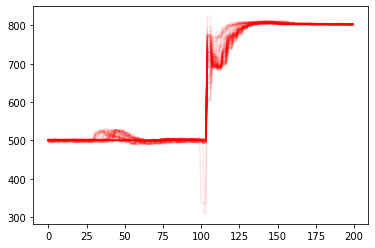

In [ ]:
log_number_list = [i for i in raw_all_ttl_df.log_number.unique() if 'idle' not in i]
for log_number in log_number_list:
    temp_df = raw_all_ttl_df.query(f"log_number == '{log_number}'")
    dsp300_flow = np.array(temp_df.esu_CHM_DSP300_FLOW)
    descent_idx_list, ascent_idx_list = search_dsp_idx(dsp300_flow)
    plt.plot(dsp300_flow[ascent_idx_list[0]-100: ascent_idx_list[0]+100], color='red', alpha=0.1)
plt.show()


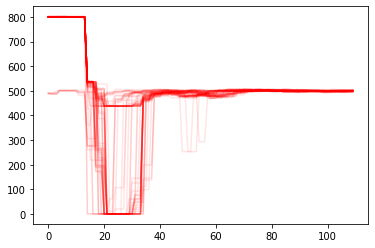

In [ ]:
log_number_list = [i for i in raw_all_ttl_df.log_number.unique() if 'idle' not in i]
for log_number in log_number_list:
    temp_df = raw_all_ttl_df.query(f"log_number == '{log_number}'")
    dsp300_flow = np.array(temp_df.esu_CHM_DSP300_FLOW)
    descent_idx_list, ascent_idx_list = search_dsp_idx(dsp300_flow)
    plt.plot(dsp300_flow[descent_idx_list[-1]-10: descent_idx_list[-1]+100], color='red', alpha=0.1)


In [ ]:
dsp300_list = []
log_number_list = [i for i in raw_all_ttl_df.log_number.unique() if 'idle' not in i]
for log_number in log_number_list:
    temp_df = raw_all_ttl_df.query(f"log_number == '{log_number}'")
    dsp300_flow = np.array(temp_df.esu_CHM_DSP300_FLOW)

    # 모든 DSP300을 첫번째 상승구간을 기준으로 맞춰줌
    descent_idx_list, ascent_idx_list = search_dsp_idx(dsp300_flow)
    dsp300_flow2 = dsp300_flow[ascent_idx_list[0]-20:ascent_idx_list[0]+60]
    
    # 모두 같은 길이(1100)로 맞추기 위해 interpolation 진행
    if len(dsp300_flow2) < 80:
        append_flow = np.ones(80 - len(dsp300_flow2)) * dsp300_flow2[-1]
        dsp300_flow3 = list(dsp300_flow2) + list(append_flow)
    else:
        dsp300_flow3 = dsp300_flow2[:80]
    dsp300_list.append(dsp300_flow3)
dsp300_df = pd.DataFrame(dsp300_list).T
dsp300_df.columns = log_number_list
# dsp300_df

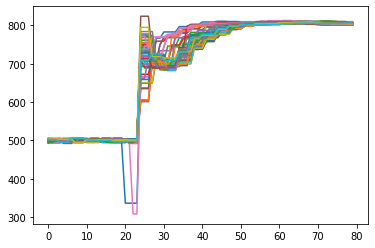

In [ ]:
plt.plot(dsp300_df)
plt.show()


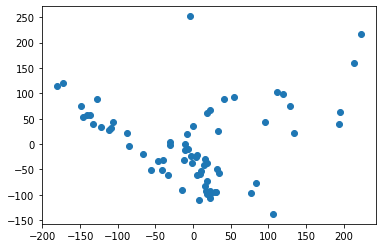

(70, 3)


In [ ]:
pca = PCA(n_components=3)
pcs2 = pca.fit_transform(dsp300_df.iloc[:].T)
plt.scatter(pcs2[:,0], pcs2[:,1])
plt.show()
print(pcs2.shape)

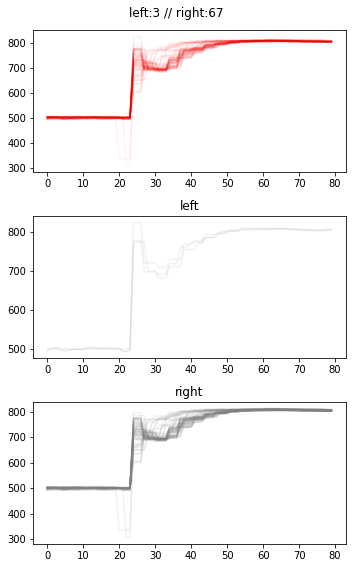

In [ ]:
comp_div_idx = -100
# comp_div_idx = 90
plt.figure(figsize=[5, 8]) 

pcs2_df = pd.DataFrame(pcs2,columns=['comp1','comp2','comp3'])
# PCA 결과를 dataframe으로 생성
pcs2_left_idx_list = pcs2_df.query(f"comp2<{comp_div_idx}").index
pcs2_left_log_list = [dsp300_df.columns[i] for i in pcs2_left_idx_list]
pcs2_right_idx_list = pcs2_df.query(f"comp2>{comp_div_idx}").index
pcs2_right_log_list = [dsp300_df.columns[i] for i in pcs2_right_idx_list]

plt.subplot(3,1,1)
plt.plot(dsp300_df[pcs2_left_log_list], color='gray', alpha=0.1, label=f"comp2 < {comp_div_idx}")
# 1st component(x-axis)가 comp_div_idx보다 작은 것들을 left로 지정
plt.plot(dsp300_df[pcs2_right_log_list], color='red', alpha=0.05, label=f"comp2 > {comp_div_idx}")
# 1st component(x-axis)가 comp_div_idx보다 큰 것들을 right 지정

plt.subplot(3,1,2)
plt.plot(dsp300_df[pcs2_left_log_list], color='gray', alpha=0.1)
plt.title(f"left")
# 1st component(x-axis)가 comp_div_idx보다 작은 것들을 left로 지정

plt.subplot(3,1,3)

plt.plot(dsp300_df[pcs2_right_log_list], color='gray', alpha=0.1)
plt.title(f"right")
# 1st component(x-axis)가 comp_div_idx보다 큰 것들을 right 지정
plt.suptitle(f"left:{len(pcs2_left_log_list)} // right:{len(pcs2_right_log_list)}")
plt.tight_layout()

plt.show()


In [ ]:
dsp300_descent_list = []
log_number_list = [i for i in raw_all_ttl_df.log_number.unique() if 'idle' not in i]
for log_number in log_number_list:
    temp_df = raw_all_ttl_df.query(f"log_number == '{log_number}'")
    dsp300_flow = np.array(temp_df.esu_CHM_DSP300_FLOW)

    # 모든 DSP300을 첫번째 상승구간을 기준으로 맞춰줌
    descent_idx_list, ascent_idx_list = search_dsp_idx(dsp300_flow)
    dsp300_flow2 = dsp300_flow[ascent_idx_list[0]+250:ascent_idx_list[0]+400]
    
    # 모두 같은 길이(1100)로 맞추기 위해 interpolation 진행
    if len(dsp300_flow2) < 150:
        append_flow = np.ones(150 - len(dsp300_flow2)) * dsp300_flow2[-1]
        dsp300_flow3 = list(dsp300_flow2) + list(append_flow)
    else:
        dsp300_flow3 = dsp300_flow2[:150]
    dsp300_descent_list.append(dsp300_flow3)
dsp300_descent_df = pd.DataFrame(dsp300_descent_list).T
dsp300_descent_df.columns = log_number_list
# dsp300_df

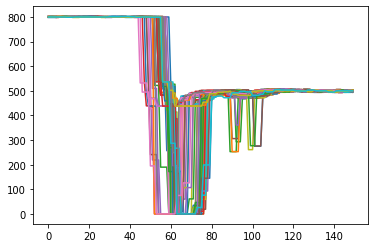

In [ ]:
plt.plot(dsp300_descent_df)
plt.show()


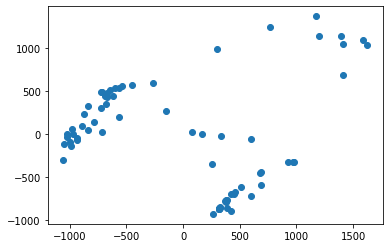

(70, 3)


In [ ]:
pca_descent = PCA(n_components=3)
pcs2_descent = pca_descent.fit_transform(dsp300_descent_df.iloc[:].T)
plt.scatter(pcs2_descent[:,0], pcs2_descent[:,1])
plt.show()
print(pcs2_descent.shape)

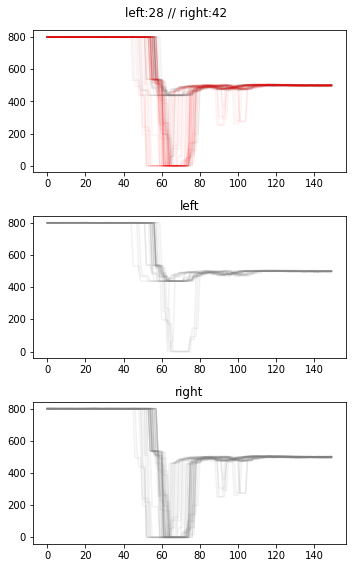

In [ ]:
comp_div_idx = -100
# comp_div_idx = 90
plt.figure(figsize=[5, 8]) 

pcs2_descent_df = pd.DataFrame(pcs2_descent,columns=['comp1','comp2','comp3'])
# PCA 결과를 dataframe으로 생성
pcs2_left_idx_list = pcs2_descent_df.query(f"comp2<{comp_div_idx}").index
pcs2_left_log_list = [dsp300_descent_df.columns[i] for i in pcs2_left_idx_list]
pcs2_right_idx_list = pcs2_descent_df.query(f"comp2>{comp_div_idx}").index
pcs2_right_log_list = [dsp300_descent_df.columns[i] for i in pcs2_right_idx_list]

plt.subplot(3,1,1)
plt.plot(dsp300_descent_df[pcs2_left_log_list], color='gray', alpha=0.1, label=f"comp2 < {comp_div_idx}")
# 1st component(x-axis)가 comp_div_idx보다 작은 것들을 left로 지정
plt.plot(dsp300_descent_df[pcs2_right_log_list], color='red', alpha=0.05, label=f"comp2 > {comp_div_idx}")
# 1st component(x-axis)가 comp_div_idx보다 큰 것들을 right 지정

plt.subplot(3,1,2)
plt.plot(dsp300_descent_df[pcs2_left_log_list], color='gray', alpha=0.1)
plt.title(f"left")
# 1st component(x-axis)가 comp_div_idx보다 작은 것들을 left로 지정

plt.subplot(3,1,3)

plt.plot(dsp300_descent_df[pcs2_right_log_list], color='gray', alpha=0.1)
plt.title(f"right")
# 1st component(x-axis)가 comp_div_idx보다 큰 것들을 right 지정
plt.suptitle(f"left:{len(pcs2_left_log_list)} // right:{len(pcs2_right_log_list)}")
plt.tight_layout()

plt.show()


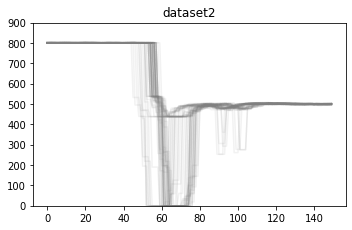

(0, 70)

In [ ]:
normal_log_list, abnormal_log_list = [], []
plt.figure(figsize=[5, 6]) 

for col in dsp300_descent_df.columns:
    dsp300_descent_flow = np.array(dsp300_descent_df[col])

    descent_idx_list, ascent_idx_list = search_dsp_idx(dsp300_descent_flow)
    if len(ascent_idx_list) < 2:
        abnormal_log_list.append(col)
        plt.subplot(2,1,2)
        plt.plot(dsp300_descent_flow, color='gray', alpha=0.1)
        plt.title('dataset2')
        plt.ylim(0, 900)

    else:
        normal_log_list.append(col)
        plt.subplot(2,1,1)
        plt.plot(dsp300_descent_flow, color='gray', alpha=0.1)
        plt.title('dataset1')
        plt.ylim(0, 900)

plt.tight_layout()
plt.show()
len(normal_log_list), len(abnormal_log_list)

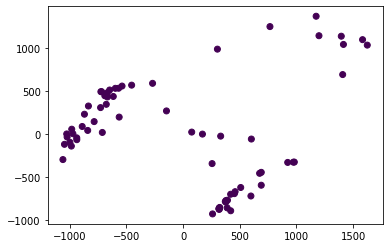

In [ ]:
# 10회차 발표자료 준비
dsp300_descent_df_columns = list(dsp300_descent_df.columns)
normal_pcs_idx = [dsp300_descent_df_columns.index(i) for i in normal_log_list]
abnormal_pcs_idx = [dsp300_descent_df_columns.index(i) for i in abnormal_log_list]

pcs_descent_df = pd.DataFrame(pcs2_descent, columns=['PC1','PC2','PC3'])
pcs_descent_df.loc[normal_pcs_idx,'index'] = 1
pcs_descent_df.loc[abnormal_pcs_idx,'index'] = 0
# pcs_df.loc[67,'index'] = 0

plt.scatter(pcs_descent_df.iloc[:,0], pcs_descent_df.iloc[:,1], c=pcs_descent_df.iloc[:,3])
plt.show()

In [ ]:
comp_div_idx = -100
# comp_div_idx = 90
plt.figure(figsize=[5, 8]) 

pcs2_df = pd.DataFrame(pcs2,columns=['comp1','comp2','comp3'])
# PCA 결과를 dataframe으로 생성
pcs2_left_idx_list = pcs2_df.query(f"comp2<{comp_div_idx}").index
pcs2_left_log_list = [dsp300_df.columns[i] for i in pcs2_left_idx_list]
pcs2_right_idx_list = pcs2_df.query(f"comp2>{comp_div_idx}").index
pcs2_right_log_list = [dsp300_df.columns[i] for i in pcs2_right_idx_list]

plt.subplot(3,1,1)
plt.plot(dsp300_df[pcs2_left_log_list], color='gray', alpha=0.1, label=f"comp2 < {comp_div_idx}")
# 1st component(x-axis)가 comp_div_idx보다 작은 것들을 left로 지정
plt.plot(dsp300_df[pcs2_right_log_list], color='red', alpha=0.05, label=f"comp2 > {comp_div_idx}")
# 1st component(x-axis)가 comp_div_idx보다 큰 것들을 right 지정

plt.subplot(3,1,2)
plt.plot(dsp300_df[pcs2_left_log_list], color='gray', alpha=0.1)
plt.title(f"left")
# 1st component(x-axis)가 comp_div_idx보다 작은 것들을 left로 지정

plt.subplot(3,1,3)

plt.plot(dsp300_df[pcs2_right_log_list], color='gray', alpha=0.1)
plt.title(f"right")
# 1st component(x-axis)가 comp_div_idx보다 큰 것들을 right 지정
plt.suptitle(f"left:{len(pcs2_left_log_list)} // right:{len(pcs2_right_log_list)}")
plt.tight_layout()

plt.show()


In [ ]:
# drop_data = [
#     "Date",
#     "state"
# ]
# nameList = list(raw_all_ttl_df.drop(drop_data,axis=1).columns)

# dataFrame = pd.DataFrame(raw_all_ttl_df.query("log_number == '1329'"))
# x = dataFrame.loc[:,nameList[:]].values

# x = StandardScaler().fit_transform(x)

# y = dataFrame.loc[:,['esu_CHM_DSP300_FLOW']].values

# pca = PCA(n_components = 2)
# principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

# finalDataFrame = pd.concat([principalDf, dataFrame[['esu_CHM_DSP300_FLOW']]], axis=1)
# # finalDataFrame

# plt.scatter(principalComponents[:,0],principalComponents[:,1])

ValueError: x and y must be the same size

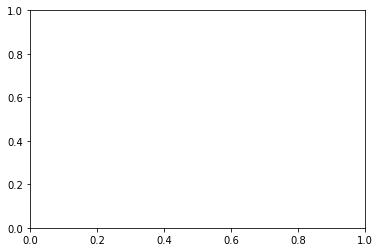

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

log_number_list = [i for i in raw_ttl_df.log_number.unique() if 'idle' not in i]
for log_number in log_number_list:
    temp_df = raw_ttl_df.query(f"log_number == '{log_number}'")

drop_data = [
    "esu_CHM_DSP300_FLOW",
    "Date",
    "state"
]
X = pd.DataFrame(raw_ttl_df.query("log_number == '1329'").drop(drop_data,axis=1))
Y = pd.DataFrame(raw_ttl_df.query("log_number == '1329'")["esu_CHM_DSP300_FLOW"])

pca = PCA(n_components=3)
pcs = pca.fit_transform(X.iloc[:,:].T)
plt.scatter(pcs,Y)
plt.show()


sklearn_pca_x = pca.fit_transform(x_std)

plt.scatter(sklearn_pca_x )
# df = pd.DataFrame(raw_ttl_df.query("log_number == '1329'"))
# d=df.drop("Date",axis=1)
# d


In [ ]:
X

,log_number,state,Date,esu_PROC_RCP_STEP,esu_RPM,esu_Bowl_Exh_R,esu_Double_Feature_SCANCOUNT,esu_IPA_SCANCOUNT,esu_MRNozzle_SCANCOUNT,esu_Chuck_Bowl_Sh1_FLOW,esu_BACK_DI_FLOW,esu_BACK_N2_FLOW,esu_BACK_HOTDI_FLOW,esu_AIR_SUCTION_FLOW,esu_CHM_EXHAUST_FLOW,esu_BACKSIDE_CAP_N2_FLOW,esu_FINAL_DIW_FLOW,esu_CHM_DHF_FLOW,esu_BACK_SC1_FLOW,esu_BACK_DHF_FLOW,esu_BACK_DSP300_FLOW,esu_AEROSOL_N2_FLOW,esu_AEROSOL_DI_FLOW,esu_CHM_SC1_DF_FLOW,esu_IPA_N2_FLOW,esu_HOT_IPA_FLOW,esu_HIPA HICV IN,esu_HIPA HICV OUT,esu_DIW1_FLOW,esu_DIW2_FLOW,esu_SSONICSWERVE,esu_WAFERSAFETY,esu_Environ_Exh,esu_SEL_THETA_POS1,esu_SEL_THETA_POS2,esu_SEL_THETA_POS3,esu_SEL_THETA_VEL1,esu_SEL_THETA_VEL2,esu_SEL_THETA_VEL3,esu_Double_Feature_THETA_POS,esu_Double_Feature_THETA_VEL,esu_Double_Feature_Z_POS,esu_IPA_THETA_POS,esu_IPA_THETA_VEL,esu_IPA_Z_POS,esu_MRNozzle_THETA_POS,esu_MRNozzle_THETA_VEL,esu_MRNozzle_Z_POS,esu_Hepa,esu_FLOW_SWITCH1,esu_FLOW_SWITCH2,esu_FLOW_SWITCH3,esu_CHAMBER_DOOR_STATUS,esu_SOUND_WAVE,esu_WAFER_TEMP,esu_HEPA_OUTPUT,esu_CDA_HEIGHT,esu_CDA_PRESS,esu_PIEZO_DRIVER_SETMODE,esu_HPU_PRESSURE,esu_REAL_BOWL_POS_STATUS,esu_AUTO_DAMPER_DEGREE_INFO1,esu_AUTO_DAMPER_DEGREE_INFO2,esu_CHAMBER_TEMPERTURE,esu_CHAMBER_HUMIDITY,...,tank10_Sub2_Density_Check,tank10_Main_Density_Check,tank10_Dnst1OfH2O2_Tank,tank10_Dnst1OfOther_Tank,tank10_Dnst2OfH2O2_Tank,tank10_Dnst2OfOther_Tank,tank10_DnstOfH2O2_Supply,tank10_DnstOfOther_Supply,tank10_RateOfACT,tank10_RateOfH2O2,tank10_RateOfDIW,tank10_TempOfMixHeater1Set,tank10_TempOfMixHeater1Act,tank10_TempOfMixHeater2Set,tank10_TempOfMixHeater2Act,tank10_TempOfSupplyHeaterSet,tank10_TempOfSupplyHeaterAct,tank10_TempOfMixtank1,tank10_TempOfMixtank2,tank10_TempOfMixtank3,tank10_TempOfReturnAct,tank10_LifeTimeSet,tank10_LifeTime,tank10_LifeCount,tank10_MainphMeter,tank10_FlowOfSub1ConPCW,tank10_FlowOfSub2ConPCW,tank10_FlowOfMainConPCW,tank10_PressOfPump,tank10_PressOfSupply,tank10_FlowOfSupply,tank10_FlowOfPCW,tank10_Exhaust,tank10_SetFlowOfACT,tank10_SetFlowOfH2O2,tank10_SetFlowOfCDIW,tank10_SetFlowOfHDIW,tank10_CurFlowOfACT,tank10_CurFlowOfH2O2,tank10_CurFlowOfCDIW,tank10_CurFlowOfHDIW,tank10_FlowOfACT,tank10_FlowOfH2O2,tank10_FlowOfCDIW,tank10_FlowOfHDIW,tank10_ACT_IN_PRESS,tank10_H2O2_IN_PRESS,tank10_Sub1phMeter,tank10_Sub2phMeter,tank10_PressOfRecycle_Filter_In,tank10_PressOfRecycle_Filter_Out,tank10_PressOfFilter_Out,tank10_CurrentOutputOfMixHeater,tank10_StateOfMixHeaterFullPower,tank10_StateOfSubCirPump,tank10_PressOfSubCirPumpInAir,tank10_StateOfMainCirPump,tank10_PressOfMainCirPumpInAir,tank10_StateOfMainSubPumpExch,tank10_TempOfDnstChemSampling,tank10_StateOfDnstMeasuring,tank10_HalogenOfUV_DS,tank10_HalogenOfUV_DR,tank10_HalogenOfNIR_DS,tank10_HalogenOfNIR_DR
5508,1329,diff_normal,2021-08-11 09:00:22.100,0.0,500.0,181.0,0.0,0.0,2.0,0.0,0.0,40.0,0.0,0.0,0.0,146.0,0.0,500.0,503.0,500.0,814.0,0.0,0.0,502.0,0.0,251.0,124.0,81.0,1220.0,1005.0,0.0,0.0,69.0,14998.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,397.0,700.0,385.0,700.0,303.0,305.0,403.0,390.0,327.0,1440.0,0.0,0.0,0.0,0.0,283.9,281.0,726.2,281.9,117.8,0.0,19.9,484.0,3009.0,1305.0,0.0,0.0,0.0,7112.0,0.0,0.0,0.0,0.0,0.0,95.0,146.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5509,1329,diff_normal,2021-08-11 09:00:22.200,0.0,500.0,181.0,0.0,0.0,2.0,0.0,0.0,40.0,0.0,0.0,0.0,146.0,0.0,500.0,500.0,500.0,814.0,0.0,0.0,499.0,0.0,251.0,124.0,81.0,1220.0,1004.0,0.0,0.0,69.0,14998.0,0.0,0.0,-54.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,397.0,700.0,385.0,700.0,303.0,305.0,403.0,390.0,327.0,1440.0,0.0,0.0,0.0,0.0,283.8,281.0,726.4,285.8,117.6,0.0,19.8,484.0,3009.0,1305.0,0.0,0.0,0.0,7112.0,0.0,0.0,0.0,0.0,0.0,95.0,146.2,0.0,0.0,0.0,0.0,0.0

## 0. Info & Summary
작성일 : 211103 / 작성자 : 류기홍

## 1. 아이템 정의
DSP300 기준 상승구간의 X 변동성을 PCA를 통해 확인

## 2. 목적
DSP300의 상승구간의 정보량을 확인하고, PCA를 바탕으로 검토


----------------------------------
## 3. 방법 및 코드

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os, warnings, shutil
import warnings, random, openpyxl
warnings.filterwarnings(action='ignore')  

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)
pd.set_option('max_columns', 130, 'max_rows', 250)



In [ ]:
def search_dsp_idx(dsp_array):
    std_list = []
    for i in range(len(dsp_array)):
        chunck = 5
        if i+chunck > len(dsp_array): break
        dsp_temp = dsp_array[i:i+chunck]
        std_list.append(np.diff(dsp_temp))
    ascent_idx_list = np.where(np.array(std_list)>100)[0]
    descent_idx_list = np.where(np.array(std_list)<-100)[0]

    # 상승/하강구간의 최초 지점을 찾아줌
    past_ascent_idx = 0
    new_ascent_idx_list = []
    for ascent_idx in ascent_idx_list:
        if past_ascent_idx + 30 < ascent_idx: 
            new_ascent_idx_list.append(ascent_idx)
        past_ascent_idx = ascent_idx

    past_descent_idx = 0
    new_descent_idx_list = []
    for descent_idx in descent_idx_list:
        if past_descent_idx + 30 < descent_idx: 
            new_descent_idx_list.append(descent_idx)
        past_descent_idx = descent_idx
    return new_descent_idx_list, new_ascent_idx_list

In [ ]:
raw_train_df = pd.read_pickle("C:\\Users\\OnePredict\\Desktop\\SEMES_work\\lotus_train_test_211019[521]\\lotus_train_df.pkl")
raw_test_df = pd.read_pickle("C:\\Users\\OnePredict\\Desktop\\SEMES_work\\lotus_train_test_211019[521]\\lotus_test_df.pkl")
print(raw_train_df.shape, raw_test_df.shape)
display(raw_train_df.head(), raw_test_df.head())

(70602, 940) (4970, 940)


,state,log_number,Date,esu_PROC_RCP_STEP,esu_RPM,esu_Bowl_Exh_R,esu_Double_Feature_SCANCOUNT,esu_IPA_SCANCOUNT,esu_MRNozzle_SCANCOUNT,esu_Chuck_Bowl_Sh1_FLOW,esu_BACK_DI_FLOW,esu_BACK_N2_FLOW,esu_BACK_HOTDI_FLOW,esu_AIR_SUCTION_FLOW,esu_CHM_EXHAUST_FLOW,esu_BACKSIDE_CAP_N2_FLOW,esu_FINAL_DIW_FLOW,esu_CHM_DHF_FLOW,esu_CHM_DSP300_FLOW,esu_BACK_SC1_FLOW,esu_BACK_DHF_FLOW,esu_BACK_DSP300_FLOW,esu_AEROSOL_N2_FLOW,esu_AEROSOL_DI_FLOW,esu_CHM_SC1_DF_FLOW,esu_IPA_N2_FLOW,esu_HOT_IPA_FLOW,esu_HIPA HICV IN,esu_HIPA HICV OUT,esu_DIW1_FLOW,esu_DIW2_FLOW,esu_SSONICSWERVE,esu_WAFERSAFETY,esu_Environ_Exh,esu_SEL_THETA_POS1,esu_SEL_THETA_POS2,esu_SEL_THETA_POS3,esu_SEL_THETA_VEL1,esu_SEL_THETA_VEL2,esu_SEL_THETA_VEL3,esu_Double_Feature_THETA_POS,esu_Double_Feature_THETA_VEL,esu_Double_Feature_Z_POS,esu_IPA_THETA_POS,esu_IPA_THETA_VEL,esu_IPA_Z_POS,esu_MRNozzle_THETA_POS,esu_MRNozzle_THETA_VEL,esu_MRNozzle_Z_POS,esu_Hepa,esu_FLOW_SWITCH1,esu_FLOW_SWITCH2,esu_FLOW_SWITCH3,esu_CHAMBER_DOOR_STATUS,esu_SOUND_WAVE,esu_WAFER_TEMP,esu_HEPA_OUTPUT,esu_CDA_HEIGHT,esu_CDA_PRESS,esu_PIEZO_DRIVER_SETMODE,esu_HPU_PRESSURE,esu_REAL_BOWL_POS_STATUS,esu_AUTO_DAMPER_DEGREE_INFO1,esu_AUTO_DAMPER_DEGREE_INFO2,esu_CHAMBER_TEMPERTURE,...,tank10_Sub2_Density_Check,tank10_Main_Density_Check,tank10_Dnst1OfH2O2_Tank,tank10_Dnst1OfOther_Tank,tank10_Dnst2OfH2O2_Tank,tank10_Dnst2OfOther_Tank,tank10_DnstOfH2O2_Supply,tank10_DnstOfOther_Supply,tank10_RateOfACT,tank10_RateOfH2O2,tank10_RateOfDIW,tank10_TempOfMixHeater1Set,tank10_TempOfMixHeater1Act,tank10_TempOfMixHeater2Set,tank10_TempOfMixHeater2Act,tank10_TempOfSupplyHeaterSet,tank10_TempOfSupplyHeaterAct,tank10_TempOfMixtank1,tank10_TempOfMixtank2,tank10_TempOfMixtank3,tank10_TempOfReturnAct,tank10_LifeTimeSet,tank10_LifeTime,tank10_LifeCount,tank10_MainphMeter,tank10_FlowOfSub1ConPCW,tank10_FlowOfSub2ConPCW,tank10_FlowOfMainConPCW,tank10_PressOfPump,tank10_PressOfSupply,tank10_FlowOfSupply,tank10_FlowOfPCW,tank10_Exhaust,tank10_SetFlowOfACT,tank10_SetFlowOfH2O2,tank10_SetFlowOfCDIW,tank10_SetFlowOfHDIW,tank10_CurFlowOfACT,tank10_CurFlowOfH2O2,tank10_CurFlowOfCDIW,tank10_CurFlowOfHDIW,tank10_FlowOfACT,tank10_FlowOfH2O2,tank10_FlowOfCDIW,tank10_FlowOfHDIW,tank10_ACT_IN_PRESS,tank10_H2O2_IN_PRESS,tank10_Sub1phMeter,tank10_Sub2phMeter,tank10_PressOfRecycle_Filter_In,tank10_PressOfRecycle_Filter_Out,tank10_PressOfFilter_Out,tank10_CurrentOutputOfMixHeater,tank10_StateOfMixHeaterFullPower,tank10_StateOfSubCirPump,tank10_PressOfSubCirPumpInAir,tank10_StateOfMainCirPump,tank10_PressOfMainCirPumpInAir,tank10_StateOfMainSubPumpExch,tank10_TempOfDnstChemSampling,tank10_StateOfDnstMeasuring,tank10_HalogenOfUV_DS,tank10_HalogenOfUV_DR,tank10_HalogenOfNIR_DS,tank10_HalogenOfNIR_DR
0,normal,1261,2021-08-10 11:33:29.000,0.0,0.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,145.0,0.0,500.0,501.0,500.0,497.0,1526.0,0.0,0.0,501.0,0.0,239.0,127.0,88.0,1133.0,988.0,0.0,0.0,70.0,-30398.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,-32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,491.0,700.0,460.0,700.0,700.0,699.0,497.0,461.0,723.0,1440.0,0.0,0.0,0.0,0.0,284.0,288.0,762.0,306.0,123.0,0.0,17.0,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,normal,1261,2021-08-10 11:33:29.100,0.0,0.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,145.0,0.0,500.0,499.0,500.0,502.0,1526.0,0.0,0.0,501.0,0.0,239.0,127.0,88.0,1154.0,996.0,0.0,0.0,70.0,-30398.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,-32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,491.0,700.0,459.9,700.0,699.9,699.0,497.0,461.0,723.0,1440.0,0.0,0.0,0.0,0.0,284.0,288.1,754.4,302.3,123.4,0.0,17.1,484.0,3009.0,1305.0,0.0,487.0,3012.0,1329.0,0.0,0.0,0.0,0.0,0.0,105.0,127.1,0.0,0.0,0.0,0.0,0.0,

,state,log_number,Date,esu_PROC_RCP_STEP,esu_RPM,esu_Bowl_Exh_R,esu_Double_Feature_SCANCOUNT,esu_IPA_SCANCOUNT,esu_MRNozzle_SCANCOUNT,esu_Chuck_Bowl_Sh1_FLOW,esu_BACK_DI_FLOW,esu_BACK_N2_FLOW,esu_BACK_HOTDI_FLOW,esu_AIR_SUCTION_FLOW,esu_CHM_EXHAUST_FLOW,esu_BACKSIDE_CAP_N2_FLOW,esu_FINAL_DIW_FLOW,esu_CHM_DHF_FLOW,esu_CHM_DSP300_FLOW,esu_BACK_SC1_FLOW,esu_BACK_DHF_FLOW,esu_BACK_DSP300_FLOW,esu_AEROSOL_N2_FLOW,esu_AEROSOL_DI_FLOW,esu_CHM_SC1_DF_FLOW,esu_IPA_N2_FLOW,esu_HOT_IPA_FLOW,esu_HIPA HICV IN,esu_HIPA HICV OUT,esu_DIW1_FLOW,esu_DIW2_FLOW,esu_SSONICSWERVE,esu_WAFERSAFETY,esu_Environ_Exh,esu_SEL_THETA_POS1,esu_SEL_THETA_POS2,esu_SEL_THETA_POS3,esu_SEL_THETA_VEL1,esu_SEL_THETA_VEL2,esu_SEL_THETA_VEL3,esu_Double_Feature_THETA_POS,esu_Double_Feature_THETA_VEL,esu_Double_Feature_Z_POS,esu_IPA_THETA_POS,esu_IPA_THETA_VEL,esu_IPA_Z_POS,esu_MRNozzle_THETA_POS,esu_MRNozzle_THETA_VEL,esu_MRNozzle_Z_POS,esu_Hepa,esu_FLOW_SWITCH1,esu_FLOW_SWITCH2,esu_FLOW_SWITCH3,esu_CHAMBER_DOOR_STATUS,esu_SOUND_WAVE,esu_WAFER_TEMP,esu_HEPA_OUTPUT,esu_CDA_HEIGHT,esu_CDA_PRESS,esu_PIEZO_DRIVER_SETMODE,esu_HPU_PRESSURE,esu_REAL_BOWL_POS_STATUS,esu_AUTO_DAMPER_DEGREE_INFO1,esu_AUTO_DAMPER_DEGREE_INFO2,esu_CHAMBER_TEMPERTURE,...,tank10_Sub2_Density_Check,tank10_Main_Density_Check,tank10_Dnst1OfH2O2_Tank,tank10_Dnst1OfOther_Tank,tank10_Dnst2OfH2O2_Tank,tank10_Dnst2OfOther_Tank,tank10_DnstOfH2O2_Supply,tank10_DnstOfOther_Supply,tank10_RateOfACT,tank10_RateOfH2O2,tank10_RateOfDIW,tank10_TempOfMixHeater1Set,tank10_TempOfMixHeater1Act,tank10_TempOfMixHeater2Set,tank10_TempOfMixHeater2Act,tank10_TempOfSupplyHeaterSet,tank10_TempOfSupplyHeaterAct,tank10_TempOfMixtank1,tank10_TempOfMixtank2,tank10_TempOfMixtank3,tank10_TempOfReturnAct,tank10_LifeTimeSet,tank10_LifeTime,tank10_LifeCount,tank10_MainphMeter,tank10_FlowOfSub1ConPCW,tank10_FlowOfSub2ConPCW,tank10_FlowOfMainConPCW,tank10_PressOfPump,tank10_PressOfSupply,tank10_FlowOfSupply,tank10_FlowOfPCW,tank10_Exhaust,tank10_SetFlowOfACT,tank10_SetFlowOfH2O2,tank10_SetFlowOfCDIW,tank10_SetFlowOfHDIW,tank10_CurFlowOfACT,tank10_CurFlowOfH2O2,tank10_CurFlowOfCDIW,tank10_CurFlowOfHDIW,tank10_FlowOfACT,tank10_FlowOfH2O2,tank10_FlowOfCDIW,tank10_FlowOfHDIW,tank10_ACT_IN_PRESS,tank10_H2O2_IN_PRESS,tank10_Sub1phMeter,tank10_Sub2phMeter,tank10_PressOfRecycle_Filter_In,tank10_PressOfRecycle_Filter_Out,tank10_PressOfFilter_Out,tank10_CurrentOutputOfMixHeater,tank10_StateOfMixHeaterFullPower,tank10_StateOfSubCirPump,tank10_PressOfSubCirPumpInAir,tank10_StateOfMainCirPump,tank10_PressOfMainCirPumpInAir,tank10_StateOfMainSubPumpExch,tank10_TempOfDnstChemSampling,tank10_StateOfDnstMeasuring,tank10_HalogenOfUV_DS,tank10_HalogenOfUV_DR,tank10_HalogenOfNIR_DS,tank10_HalogenOfNIR_DR
0,normal,1326,2021-08-11 08:54:41.000,0.0,0.0,202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,500.0,496.0,0.0,800.0,0.0,0.0,500.0,0.0,246.0,125.0,86.0,0.0,0.0,0.0,0.0,70.0,-30399.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,-32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,398.0,700.0,385.0,700.0,304.0,306.0,404.0,390.0,329.0,1440.0,0.0,0.0,0.0,0.0,284.0,287.0,726.0,276.0,115.0,0.0,21.0,484.0,3009.0,1305.0,0.0,0.0,0.0,7112.0,0.0,0.0,0.0,0.0,0.0,95.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,normal,1326,2021-08-11 08:54:41.100,0.0,0.0,202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,500.0,496.0,0.0,800.0,0.0,0.0,500.0,0.0,246.0,125.0,87.0,0.0,0.0,0.0,0.0,71.0,-30399.0,0.0,0.0,0.0,0.0,0.0,-24549.0,0.0,-500.0,-24849.0,0.0,0.0,-32700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,627.0,272.0,700.0,398.0,700.0,385.0,700.0,304.0,306.0,404.0,390.0,329.0,1440.0,0.0,0.0,0.0,0.0,283.9,286.7,724.4,273.9,115.1,0.0,20.9,484.0,3009.0,1305.0,0.0,0.0,0.0,7112.0,0.0,0.0,0.0,0.0,0.0,95.0,130.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,